**Author:** Zidong Chen<br />
**Date:** 2024/06/22<br />
**Description:** This is a simple and effective trick to help with the numerical stability of the GP model.

In [140]:
import torch
import torch.nn as nn
import core.kernel as kernel
from matplotlib import pyplot as plt
import os
import numpy as np
# Variational Sparse Gaussian Processes

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # Fixing strange error if run in MacOS

JITTER = 1e-3
EPS = 1e-10
PI = 3.1415
torch.set_default_dtype(torch.float32)

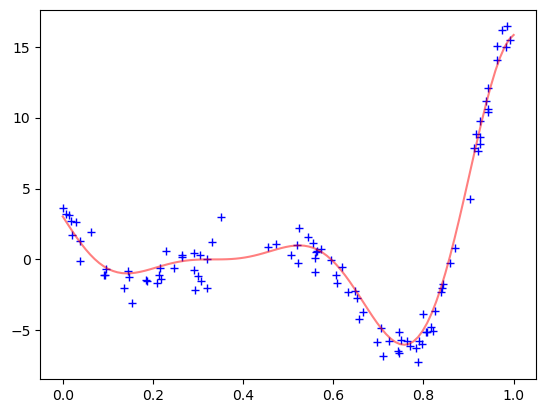

In [160]:
#train_set
torch.manual_seed(4)

xtr = torch.rand(100, 1)
ytr = ((6 * xtr - 2) ** 2) * torch.sin(12 * xtr - 4) + torch.randn(100, 1) * 1

#test_set
xte = torch.linspace(0, 1, 100).view(-1, 1)
yte = ((6 * xte - 2) ** 2) * torch.sin(12 * xte - 4)

#plot the data

plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha=0.5)
plt.show()

**It was discovered that numerical errors occur when calculating the covariance of very close points, so those points were removed.
You can try running this notebook without using this module (in the next chunck) first. During training, a non-positive-definite issue will occur.
 Then, rerun the entire file. After removing one point, this issue will not occur. Additionally, this point has very little contribution to the model.**

In [161]:
def remove_similar_data(x, y, threshold=1e-4):
    # Calculate pairwise distances
    distances = torch.cdist(x, x, p=2)

    # Create a mask to identify points within the threshold
    mask = distances < threshold

    # Zero out the diagonal to ignore self-comparison
    mask.fill_diagonal_(False)

    # Use the upper triangle of the mask to avoid double marking
    mask_upper = torch.triu(mask, diagonal=1)

    # Identify indices of points to keep
    to_remove = mask_upper.any(dim=0)
    to_keep = ~to_remove

    return xtr[to_keep], ytr[to_keep]


xtr, ytr = remove_similar_data(xtr, ytr)
print(xtr.size())

torch.Size([99, 1])


In [152]:
num_inducing = 20
subset_indices = torch.randperm(len(xtr))[:num_inducing]
xm = nn.Parameter(xtr[subset_indices])  #Inducing point we want to optimize
print(xtr.size())
print(ytr.size())
print(xm.size())

torch.Size([99, 1])
torch.Size([99, 1])
torch.Size([20, 1])


In [153]:
# define kernel parameters
log_length_scale = nn.Parameter(torch.zeros(xte.size(1)))
log_scale = nn.Parameter(torch.zeros(1))
log_beta = nn.Parameter(torch.ones(1) * -4)  # this is a large noise. we optimize to shrink it to a proper value.

In [154]:
def kernel(X1, X2, log_length_scale, log_scale):  # 定义核函数没有加linear

    X1 = X1 / log_length_scale.exp()
    X2 = X2 / log_length_scale.exp()

    X1_norm2 = X1 * X1
    X2_norm2 = X2 * X2

    K = -2.0 * X1 @ X2.t() + X1_norm2.expand(X1.size(0), X2.size(0)) + X2_norm2.t().expand(X1.size(0), X2.size(
        0))  #this is the effective Euclidean distance matrix between X1 and X2.
    K = log_scale.exp() * torch.exp(-0.5 * K)
    return K

In [155]:
def nlb(xtr, ytr, log_length_scale, log_scale, log_beta,
        xm):  # negtive lower bound as the loss function we want to minimize later

    n = xtr.size(0)
    #xms=softplus(xm)
    K_mm = kernel(xm, xm, log_length_scale, log_scale) + JITTER * torch.eye(xm.size(0))
    K_mn = kernel(xm, xtr, log_length_scale, log_scale)
    K_nn = kernel(xtr, xtr, log_length_scale, log_scale)
    L = torch.linalg.cholesky(K_mm)
    A, _ = torch.triangular_solve(K_mn, L, upper=False)
    A = A * torch.sqrt(log_beta.exp())
    AAT = A @ A.t()
    B = torch.eye(xm.size(0)) + AAT
    LB = torch.linalg.cholesky(B)

    c, _ = torch.triangular_solve(A @ ytr, LB, upper=False)
    c = c * torch.sqrt(log_beta.exp())
    nlb = n / 2 * torch.log(2 * torch.tensor(PI)) + torch.sum(torch.log(torch.diagonal(LB))) + n / 2 * torch.log(
        1 / log_beta.exp()) + \
          log_beta.exp() / 2 * torch.sum(ytr * ytr) - 0.5 * torch.sum(c.squeeze() * c.squeeze()) + \
          log_beta.exp() / 2 * torch.sum(torch.diagonal(K_nn)) - 0.5 * torch.trace(AAT)
    return nlb

In [156]:
def OPT(xm, xtr, ytr, log_length_scale, log_scale, log_beta):
    #xms=softplus(xm)
    K_mm = kernel(xm, xm, log_length_scale, log_scale) + JITTER * torch.eye(xm.size(0))
    K_mm_inv = torch.inverse(K_mm)
    K_mn = kernel(xm, xtr, log_length_scale, log_scale)
    K_nm = K_mn.t()
    sigma = torch.inverse(K_mm + log_beta.exp() * K_mn @ K_nm)

    mean_m = log_beta.exp() * (K_mm @ sigma @ K_mn) @ ytr
    A_m = K_mm @ sigma @ K_mm
    return mean_m, A_m, K_mm_inv  #we need to use K_mm inverse for prediction

#mean_m,A_m,K_mm_inv=OPT(xm,xtr,ytr,log_length_scale, log_scale, log_beta)

In [157]:
%%time
optimizer = torch.optim.LBFGS([log_length_scale, log_scale, log_beta, xm], lr=0.3)
iteration_counter = [0]


def closure():
    iteration_counter[0] += 1
    optimizer.zero_grad()  # Clear the gradients
    loss = nlb(xtr, ytr, log_length_scale, log_scale, log_beta, xm)  # Compute the loss
    loss.backward()
    print(f"Iteration {iteration_counter[0]}: Loss = {loss.item()}")
    return loss


optimizer.step(closure)
print(xtr.dtype)

Iteration 1: Loss = 317.78692626953125
Iteration 2: Loss = 312.88336181640625
Iteration 3: Loss = 311.8236389160156
Iteration 4: Loss = 311.4519958496094
Iteration 5: Loss = 311.2842712402344
Iteration 6: Loss = 311.197021484375
Iteration 7: Loss = 311.1430358886719
Iteration 8: Loss = 311.1005554199219
Iteration 9: Loss = 311.0559387207031
Iteration 10: Loss = 310.9912414550781
Iteration 11: Loss = 310.825439453125
Iteration 12: Loss = 310.5555114746094
Iteration 13: Loss = 309.4761657714844
Iteration 14: Loss = 295.31292724609375
Iteration 15: Loss = 880.3892822265625
Iteration 16: Loss = 595.0198364257812
Iteration 17: Loss = 434.8980712890625
Iteration 18: Loss = 272.00238037109375
Iteration 19: Loss = 263.8478088378906
Iteration 20: Loss = 246.6800079345703
torch.float32
CPU times: total: 484 ms
Wall time: 57.9 ms


In [158]:
def forward(xte, log_length_scale, log_scale, log_beta, xm, mean_m, A_m, K_mm_inv):
    K_tt = kernel(xte, xte, log_length_scale, log_scale)
    K_tm = kernel(xte, xm, log_length_scale, log_scale)
    K_mt = K_tm.t()
    ypred = (K_tm @ K_mm_inv) @ mean_m
    yvar = K_tt - K_tm @ K_mm_inv @ K_mt + K_tm @ K_mm_inv @ A_m @ K_mm_inv @ K_mt
    yvar = yvar.diag().view(-1, 1)
    return ypred, yvar

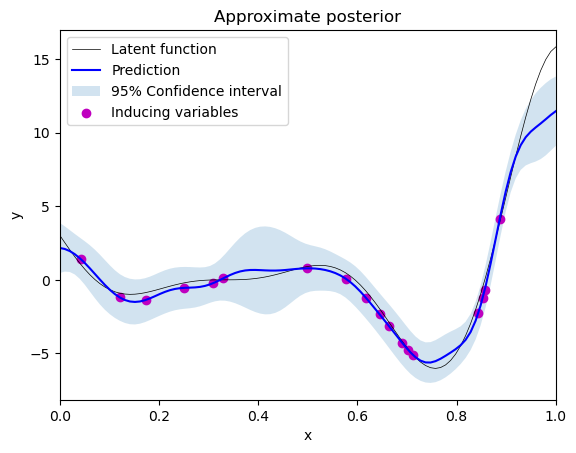

In [159]:
with torch.no_grad():
    mean_m, A_m, K_mm_inv = OPT(xm, xtr, ytr, log_length_scale, log_scale, log_beta)
    ypred, yvar = forward(xte, log_length_scale, log_scale, log_beta, xm, mean_m, A_m, K_mm_inv)
plt.plot(xte.numpy(), yte.numpy(), label='Latent function', c='k', lw=0.5)
plt.plot(xte.numpy(), ypred.detach(), label='Prediction', c='b')
plt.fill_between(xte.squeeze().numpy(),
                 ypred.squeeze().detach().numpy() - 1.96 * np.sqrt(yvar.squeeze().detach().numpy()),
                 ypred.squeeze().detach().numpy() + 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), alpha=0.2,
                 label='95% Confidence interval')
plt.scatter(xm.detach().numpy(), mean_m.detach().numpy(), label='Inducing variables', c='m')
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 1)
plt.legend();